🔄 Treinando LSTM ...


C:\Users\guiga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step 
✅ LSTM treinado - MAPE=7.50%
🔄 Treinando GRU ...


C:\Users\guiga\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step 
✅ GRU treinado - MAPE=3.20%
🔄 Treinando BiLSTM ...


C:\Users\guiga\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step
✅ BiLSTM treinado - MAPE=10.26%


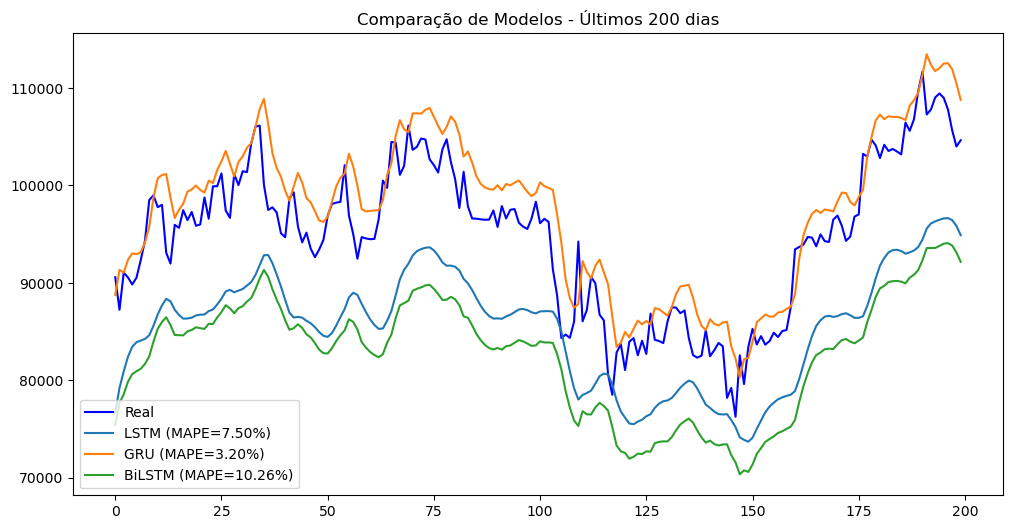

📊 Resultados Finais:
LSTM: MAPE=7.50%
GRU: MAPE=3.20%
BiLSTM: MAPE=10.26%


In [3]:
# ====================================
# 📌 Etapa 1 - Imports
# ====================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

# Garantir diretórios
os.makedirs('results', exist_ok=True)
os.makedirs('outputs', exist_ok=True)

# ====================================
# 📌 Etapa 2 - Carregar e preparar dados
# ====================================
df = pd.read_csv('data/btc_limpo.csv', parse_dates=['Date'])
df = df.set_index('Date')
df = df[['Close']]  # usamos só o preço de fechamento

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df)

lookback = 60  # janelas de 60 dias

def create_sequences(data, lookback=60):
    X, y = [], []
    for i in range(lookback, len(data)):
        X.append(data[i-lookback:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, lookback)

# reshape para [samples, time_steps, features]
X = X.reshape((X.shape[0], X.shape[1], 1))

# Divisão treino/teste
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

# ====================================
# 📌 Etapa 3 - Função para criar e treinar modelos
# ====================================
def build_and_train(model_type, units=64, epochs=20, batch_size=32):
    model = Sequential()

    if model_type == 'LSTM':
        model.add(LSTM(units=units, return_sequences=True, input_shape=(lookback, 1)))
        model.add(Dropout(0.2))
        model.add(LSTM(units=units))
        model.add(Dropout(0.2))
    elif model_type == 'GRU':
        model.add(GRU(units=units, return_sequences=True, input_shape=(lookback, 1)))
        model.add(Dropout(0.2))
        model.add(GRU(units=units))
        model.add(Dropout(0.2))
    elif model_type == 'BiLSTM':
        model.add(Bidirectional(LSTM(units=units, return_sequences=True), input_shape=(lookback, 1)))
        model.add(Dropout(0.2))
        model.add(Bidirectional(LSTM(units=units)))
        model.add(Dropout(0.2))

    model.add(Dense(1))
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0,
                        validation_split=0.1, shuffle=False)

    return model, history

# ====================================
# 📌 Etapa 4 - Treinar e avaliar modelos
# ====================================
results = {}
models = {}

for m in ['LSTM', 'GRU', 'BiLSTM']:
    print(f"🔄 Treinando {m} ...")
    model, history = build_and_train(m, units=64, epochs=20, batch_size=32)
    
    # Previsões
    preds = model.predict(X_test)
    preds_rescaled = scaler.inverse_transform(preds.reshape(-1,1))
    y_true_rescaled = scaler.inverse_transform(y_test.reshape(-1,1))
    
    # Métrica
    mape = mean_absolute_percentage_error(y_true_rescaled, preds_rescaled) * 100
    results[m] = mape
    models[m] = (model, preds_rescaled, y_true_rescaled)

    # Gráfico individual
    plt.figure(figsize=(12,6))
    plt.plot(y_true_rescaled[-200:], label='Real', color='blue')
    plt.plot(preds_rescaled[-200:], label='Previsto', color='red')
    plt.title(f"{m} | MAPE={mape:.2f}%")
    plt.legend()
    plt.savefig(f"results/{m}_01-10.png", dpi=300)
    plt.close()

    print(f"✅ {m} treinado - MAPE={mape:.2f}%")

# ====================================
# 📌 Etapa 5 - Comparação final
# ====================================
plt.figure(figsize=(12,6))
plt.plot(models['LSTM'][2][-200:], label='Real', color='blue')

for m, (model, preds, y_true) in models.items():
    plt.plot(preds[-200:], label=f'{m} (MAPE={results[m]:.2f}%)')

plt.title("Comparação de Modelos - Últimos 200 dias")
plt.legend()
plt.savefig("results/comparacao_modelos_01-10.png", dpi=300)
plt.show()

print("📊 Resultados Finais:")
for m, score in results.items():
    print(f"{m}: MAPE={score:.2f}%")
